# Exposure to change in heatwave occurrance 

- INFANTS and over 65


> Now using the new heatwave definitions that depend on both the tmin and tmax percentiles

---

> Using upscaled population data for pre-2000, this is an approximation! Needs to be shown as such on the graphs 

---

> Using VERY ROUGH ESTIMATE of yearly newborn pop, this is EVEN MORE ROUGH for the pre-2000 data

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import xarray as xr
import matplotlib.pyplot as plt

from cartopy import crs as ccrs
from scipy import stats

from config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

In [2]:
# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [3]:
MAP_PROJECTION = ccrs.EckertIII()

In [4]:
MAX_YEAR = 2021

REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('../results/heatwaves/').absolute()

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet'/ 'heatwaves'/ 'results_2022'

GPW_FILE = DATA_SRC/ 'lancet/population/UN WPP-Adjusted Population Count v4.11 2000-2020 15min era compat.nc'
# POPULATION_VAR = 'UN WPP-Adjusted Population Count, v4.11 (2000-2020)'

# DEMOGRAPHICS_TOTALS_FILE = POP_DATA_SRC / 'demographics_2000_2020_15_min_era_compat.nc'
DEMOGRAPHICS_TOTALS_FILE = POP_DATA_SRC / 'demographics_hybrid_1950_2020_15_min_era_compat.nc'

In [5]:
MIN_YEAR = 1980

In [6]:
INFANTS_TOTALS_FILE = POP_DATA_SRC / 'infants_1950_2020_hybrid_15_min_era_compat.nc'

In [7]:
# population_data = xr.open_dataset('demographics_hybrid_1950_2020_15_min.nc')
# population_total = population_data.sum(dim='age_band_lower_bound')

In [8]:
# population_total = population_data.sum(dim='age_band_lower_bound')



# Load Data

## Load GPW data

In [9]:
gpw_dat = xr.open_dataset(GPW_FILE)

## Load country data

In [10]:
COUNTRIES_RASTER = gpw_dat['National Identifier Grid, v4.11 (2010): National Identifier Grid'].load()

In [11]:
land_mask  = (COUNTRIES_RASTER < 2000)

## Load population and demographic data

In [12]:
# population = gpw_dat[POPULATION_VAR]

In [13]:
demographics_totals = xr.open_dataarray(DEMOGRAPHICS_TOTALS_FILE)
# population_over_65 = demographics_totals.sel(age_band_lower_bound=65).load()

In [14]:
population_infants = xr.open_dataarray(INFANTS_TOTALS_FILE)

## Extrapolate demographic data to 2021

In [15]:
population_over_65 = (
    xr.concat([demographics_totals, 
               demographics_totals.interp(year=2021, kwargs=dict(fill_value="extrapolate")).compute()
              ], 'year').sel(age_band_lower_bound=65).load())

In [16]:
population_infants = (
    xr.concat([population_infants, 
               population_infants.interp(year=2021, kwargs=dict(fill_value="extrapolate")).compute()
              ], 'year').load())

## Load heatwave lengths and counts data

> TODO would like to split this up into yearly files so I only need to re-do one year at a time...

In [17]:
heatwave_metrics_files = sorted((INTERMEDIATE_RESULTS_FOLDER / 'heatwave_days_era5').glob('*.nc'))
heatwave_metrics = xr.open_mfdataset(heatwave_metrics_files, combine='by_coords')

### Calculate the difference from the mean number of days and number of events

> NOTE: we do a sort of double-difference in this case, since we first define heatwaves based on a historical distribution (99th percentile) then we again calculate the change. Question is open as to whether it's also critical to use the same period for calculating the percentile and calculating the reference period. Also a question whether we should compare the change in exposures rather than the change in heatwaves. The problem (or maybe it's a benefit??) is that you also mix in changes in total population and demographics


In [18]:
heatwaves_metrics_reference = heatwave_metrics.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwave_metrics_delta = heatwave_metrics - heatwaves_metrics_reference

## Calculate some utility data

In [19]:
# Get the grid weighting factor from the latitude
cos_lat = np.cos(np.radians(heatwave_metrics.latitude))
# Get the total population for normalising
total_pop_over_65 = population_over_65.sum(dim=['latitude', 'longitude'], skipna=True)

# Calculate total exposures and save for all metrics

Because the calculation is the same for all metrics, we can calculated it once on the dataset and save

In [20]:
exposures_over65 = heatwave_metrics_delta * population_over_65

In [22]:
exposures_over65 = exposures_over65.drop('age_band_lower_bound')

In [62]:
exposures_over65.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_over65_multi_threshold_{MIN_YEAR}-{MAX_YEAR}.nc')

In [23]:
exposures_infants = heatwave_metrics_delta * population_infants

In [24]:
exposures_infants = exposures_infants.drop('age_band_lower_bound')

In [45]:
exposures_infants.to_netcdf(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_infants_multi_threshold_{MIN_YEAR}-{MAX_YEAR}.nc')

In [19]:
# exposures = xr.open_dataset(INTERMEDIATE_RESULTS_FOLDER / f'heatwave_exposure_change_multi_threshold_2000-{MAX_YEAR}.nc')

## Total Exposure to change in  to heatwaves

Calculate exposure changes in terms of difference aspects of heatwaves - frequency, length, load. 


In [25]:
total_exposures_over65 = exposures_over65.sum(dim=['latitude', 'longitude']).to_dataframe()

total_exposures_infants = exposures_infants.sum(dim=['latitude', 'longitude']).to_dataframe()

In [26]:
total_exposures_over65.to_csv(RESULTS_FOLDER / 'heatwave_exposure_change_totals_over65.csv')

In [27]:
total_exposures_infants.to_csv(RESULTS_FOLDER / 'heatwave_exposure_change_totals_infants.csv')

# Weighted mean change

In [28]:
weighted_mean_over65 = ((exposures_over65 / population_over_65.sum(dim=['latitude', 'longitude']))
                        .where(~np.isnan(population_over_65))
                          .sum(dim=['latitude', 'longitude'],
                               skipna=True).to_dataframe()).drop('age_band_lower_bound', axis=1)

In [29]:
weighted_mean_infants = ((exposures_infants / population_infants.sum(dim=['latitude', 'longitude']))
                         .where(~np.isnan(population_infants))
                          .sum(dim=['latitude', 'longitude'],
                               skipna=True).to_dataframe()
                        .drop('age_band_lower_bound', axis=1))

In [31]:
weighted_mean_over65.to_csv(RESULTS_FOLDER / 'heatwave_days_change_weighted_over65.csv')
weighted_mean_infants.to_csv(RESULTS_FOLDER / 'heatwave_days_change_weighted_infants.csv')

#### Directly save the weighted vs overall

In [32]:
heatwave_metrics_delta_mean = (
    (heatwave_metrics_delta  * cos_lat)
    .where(~np.isnan(population_over_65.max(dim='year')))
    .mean(dim=['latitude', 'longitude'],
            skipna=True)
    .to_dataframe()
    .drop('age_band_lower_bound', axis=1))

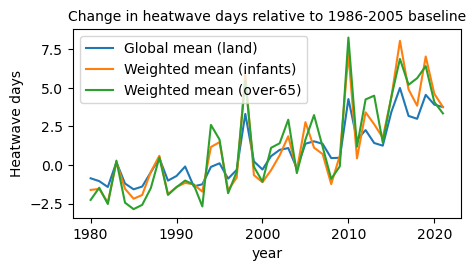

In [110]:
f, ax = plt.subplots(1,1)

heatwave_metrics_delta_mean.heatwaves_days.plot(ax=ax, label='Global mean (land)')

weighted_mean_infants.heatwaves_days.plot(ax=ax, label='Weighted mean (infants)')
weighted_mean_over65.heatwaves_days.plot(ax=ax, label='Weighted mean (over-65)')
ax.legend()
ax.set(
    ylabel='Heatwave days',
    title='Change in heatwave days relative to 1986-2005 baseline'
)
f.savefig(RESULTS_FOLDER / 'weighted heatwave change comparison.png', dpi=300)
f.savefig(RESULTS_FOLDER / 'weighted heatwave change comparison.pdf')

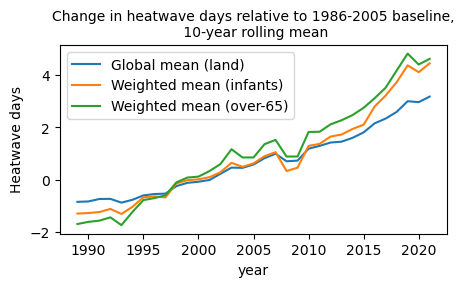

In [111]:
f, ax = plt.subplots(1,1)
n = 10
heatwave_metrics_delta_mean.rolling(n).mean().heatwaves_days.plot(ax=ax, label='Global mean (land)')

weighted_mean_infants.rolling(n).mean().heatwaves_days.plot(ax=ax, label='Weighted mean (infants)')
weighted_mean_over65.rolling(n).mean().heatwaves_days.plot(ax=ax, label='Weighted mean (over-65)')
ax.legend()
ax.set(
    ylabel='Heatwave days',
    title=f'Change in heatwave days relative to 1986-2005 baseline,\n {n}-year rolling mean'
)
f.savefig(RESULTS_FOLDER / 'weighted rolling heatwave change comparison.png', dpi=300)
f.savefig(RESULTS_FOLDER / 'weighted rolling heatwave change comparison.pdf')

In [39]:
n=10
rolling_stats = pd.DataFrame({
    'heatwave_days_change_land':heatwave_metrics_delta_mean.rolling(n).mean().heatwaves_days,
    'heatwave_days_change_infants': weighted_mean_infants.rolling(n).mean().heatwaves_days,
    'heatwave_days_change_over65': weighted_mean_over65.rolling(n).mean().heatwaves_days}).dropna()

In [41]:
rolling_stats.to_csv(RESULTS_FOLDER / 'heatwave_days_change_10_year_rolling_mean.csv')

In [115]:
heatwave_metrics_delta_mean.rolling(n).mean().heatwaves_days

year
1980         NaN
1981         NaN
1982         NaN
1983         NaN
1984         NaN
1985         NaN
1986         NaN
1987         NaN
1988         NaN
1989   -0.834740
1990   -0.819636
1991   -0.724707
1992   -0.720726
1993   -0.864079
1994   -0.756483
1995   -0.587855
1996   -0.536658
1997   -0.521043
1998   -0.234367
1999   -0.109826
2000   -0.068036
2001   -0.000997
2002    0.235655
2003    0.470424
2004    0.460962
2005    0.587855
2006    0.829715
2007    0.998485
2008    0.712408
2009    0.735668
2010    1.192364
2011    1.298055
2012    1.426261
2013    1.459052
2014    1.606201
2015    1.811839
2016    2.157549
2017    2.338401
2018    2.592988
2019    3.000924
2020    2.964666
2021    3.176886
Name: heatwaves_days, dtype: float64

In [125]:
weighted_mean_infants.rolling(n).mean().heatwaves_days

year
1980         NaN
1981         NaN
1982         NaN
1983         NaN
1984         NaN
1985         NaN
1986         NaN
1987         NaN
1988         NaN
1989   -1.280938
1990   -1.261876
1991   -1.222836
1992   -1.105482
1993   -1.295705
1994   -1.024921
1995   -0.658506
1996   -0.627277
1997   -0.664585
1998   -0.130316
1999   -0.006866
2000    0.023905
2001    0.106208
2002    0.294204
2003    0.652881
2004    0.500546
2005    0.630204
2006    0.905787
2007    1.058758
2008    0.340843
2009    0.467177
2010    1.298350
2011    1.374914
2012    1.653702
2013    1.731570
2014    1.943936
2015    2.105739
2016    2.797833
2017    3.216662
2018    3.724689
2019    4.366994
2020    4.108593
2021    4.441676
Name: heatwaves_days, dtype: float64

In [116]:
weighted_mean_over65.rolling(n).mean().heatwaves_days

year
1980         NaN
1981         NaN
1982         NaN
1983         NaN
1984         NaN
1985         NaN
1986         NaN
1987         NaN
1988         NaN
1989   -1.679946
1990   -1.597039
1991   -1.550611
1992   -1.425372
1993   -1.722203
1994   -1.218162
1995   -0.767169
1996   -0.691822
1997   -0.584853
1998   -0.090477
1999    0.092180
2000    0.127260
2001    0.339431
2002    0.607721
2003    1.169823
2004    0.857326
2005    0.857681
2006    1.364017
2007    1.525550
2008    0.892065
2009    0.894476
2010    1.828591
2011    1.836246
2012    2.120370
2013    2.275973
2014    2.473990
2015    2.749659
2016    3.113631
2017    3.515304
2018    4.167814
2019    4.817008
2020    4.399165
2021    4.614480
Name: heatwaves_days, dtype: float64

In [126]:
(weighted_mean_over65 - heatwave_metrics_delta_mean).rolling(n).mean().heatwaves_days

year
1980         NaN
1981         NaN
1982         NaN
1983         NaN
1984         NaN
1985         NaN
1986         NaN
1987         NaN
1988         NaN
1989   -0.845206
1990   -0.777402
1991   -0.825905
1992   -0.704646
1993   -0.858124
1994   -0.461679
1995   -0.179314
1996   -0.155164
1997   -0.063810
1998    0.143890
1999    0.202006
2000    0.195296
2001    0.340428
2002    0.372066
2003    0.699398
2004    0.396365
2005    0.269826
2006    0.534303
2007    0.527065
2008    0.179656
2009    0.158808
2010    0.636227
2011    0.538190
2012    0.694109
2013    0.816921
2014    0.867789
2015    0.937820
2016    0.956082
2017    1.176903
2018    1.574826
2019    1.816084
2020    1.434499
2021    1.437594
Name: heatwaves_days, dtype: float64

In [127]:
(weighted_mean_infants - heatwave_metrics_delta_mean).rolling(n).mean().heatwaves_days

year
1980         NaN
1981         NaN
1982         NaN
1983         NaN
1984         NaN
1985         NaN
1986         NaN
1987         NaN
1988         NaN
1989   -0.446198
1990   -0.442240
1991   -0.498130
1992   -0.384755
1993   -0.431625
1994   -0.268438
1995   -0.070651
1996   -0.090620
1997   -0.143541
1998    0.104050
1999    0.102960
2000    0.091941
2001    0.107205
2002    0.058549
2003    0.182457
2004    0.039584
2005    0.042349
2006    0.076072
2007    0.060272
2008   -0.371565
2009   -0.268491
2010    0.105986
2011    0.076858
2012    0.227441
2013    0.272519
2014    0.337736
2015    0.293900
2016    0.640284
2017    0.878261
2018    1.131701
2019    1.366070
2020    1.143927
2021    1.264790
Name: heatwaves_days, dtype: float64

<AxesSubplot:xlabel='year'>

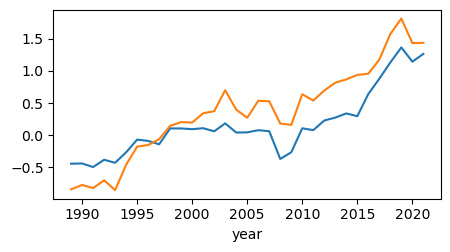

In [124]:
(weighted_mean_infants - heatwave_metrics_delta_mean).rolling(n).mean().heatwaves_days.plot()

(weighted_mean_over65 - heatwave_metrics_delta_mean).rolling(n).mean().heatwaves_days.plot()

# Test plots


<AxesSubplot:xlabel='year'>

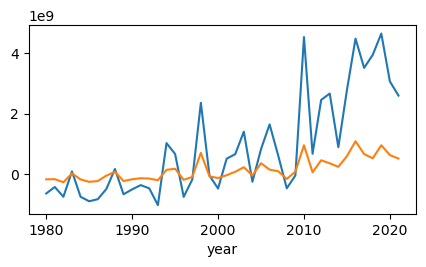

In [52]:
total_exposures_over65.heatwaves_days.plot()
total_exposures_infants.heatwaves_days.plot()

<AxesSubplot:xlabel='year'>

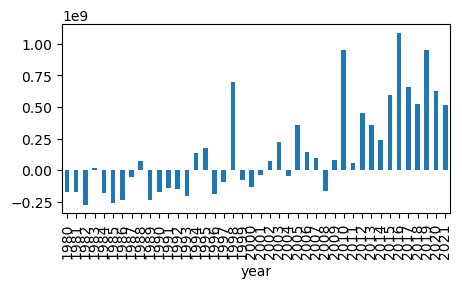

In [53]:
total_exposures_infants.heatwaves_days.plot.bar()

In [54]:
plot_data = pd.concat([total_exposures_over65.heatwaves_days, total_exposures_infants.heatwaves_days], axis=1)
plot_data.columns = ['over_65', 'newborn']

<AxesSubplot:xlabel='year'>

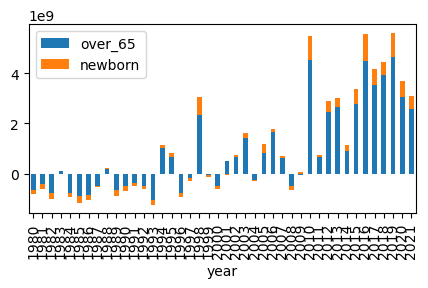

In [55]:
plot_data.plot.bar(stacked=True)